In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import gc

In [2]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [3]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [4]:
results_file = "results/humanpbmc.h5ad"

In [5]:
adata = sc.read_10x_mtx("filtered_feature_bc_matrix", var_names="gene_symbols", cache=True)

... reading from cache file cache/filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata.var_names_make_unique()

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


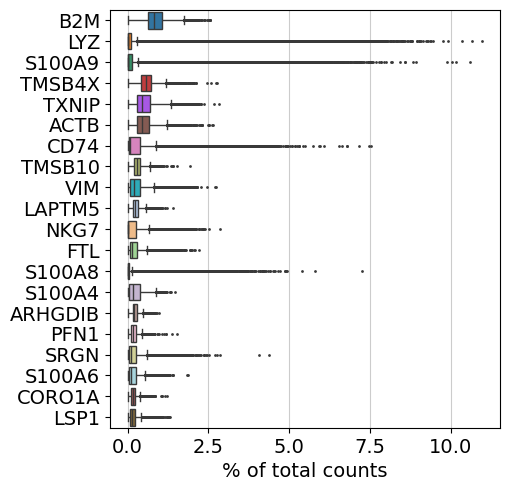

In [7]:
# Show the genes with the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
# Perform some basic filtering: # Filter out cells that have less than 100 genes expressed and genes that are detected in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 48 cells that have less than 200 genes expressed
filtered out 3489 genes that are detected in less than 3 cells


In [9]:
# Annotate the group of mitochondrial and and ribosomal genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], log1p=True, inplace=True)

/home/eaderogba279/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


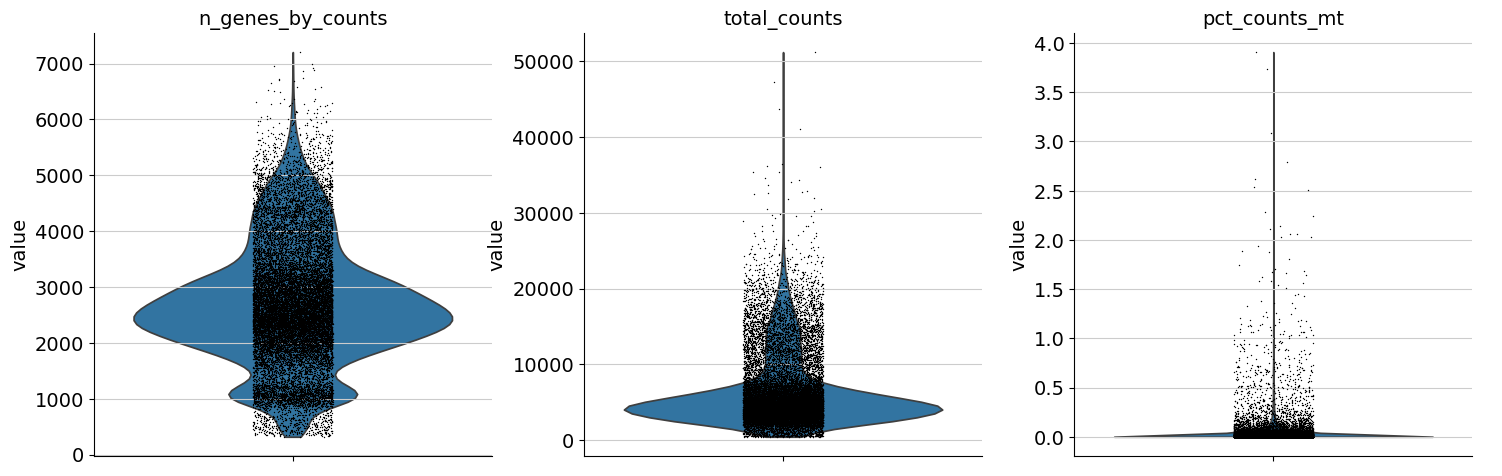

/home/eaderogba279/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


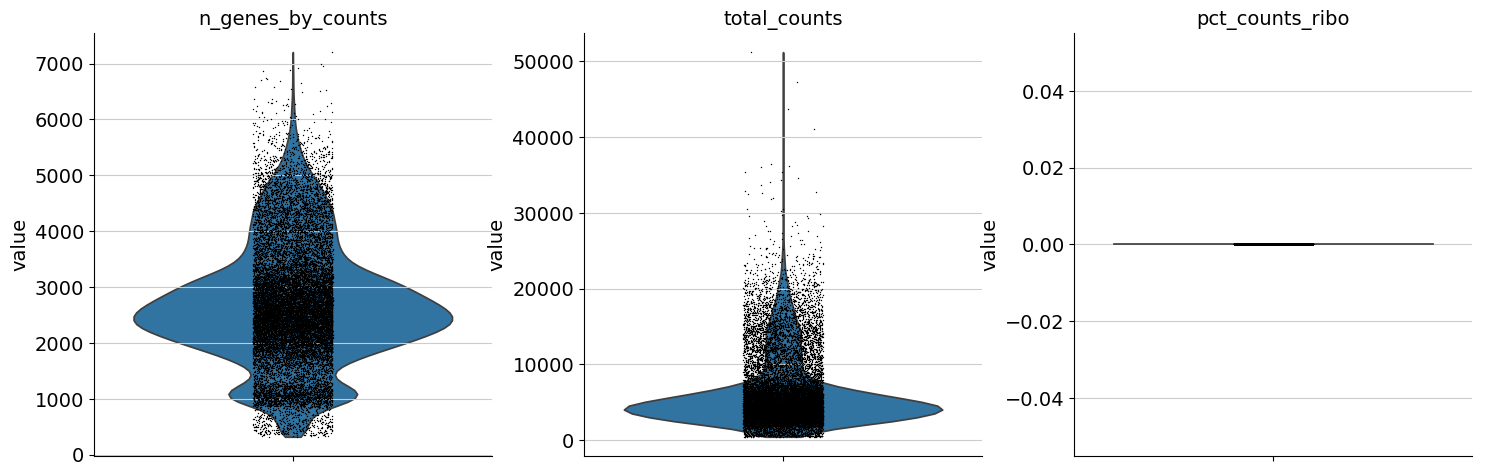

In [10]:
# Visulaise the computed Statistics
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], multi_panel=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_ribo"], multi_panel=True)

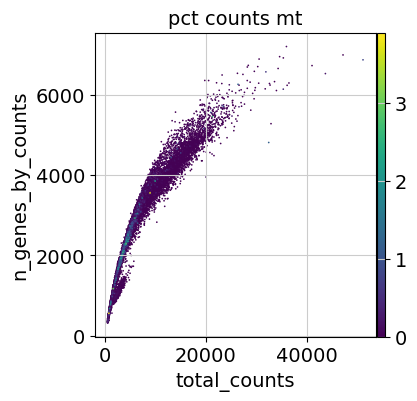

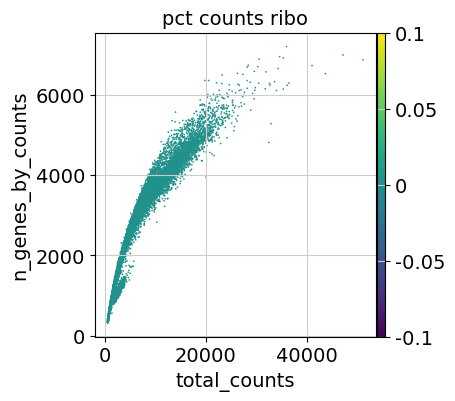

In [11]:
# Joint visualisation of the computed metrics, using a scatter plot colored by pct_counts_mt
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_ribo")

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many counts
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
#adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [14]:
# Assign a uniform sample_id to all cells
adata.obs['sample_id'] = "HumanPBMC"

/tmp/ipykernel_73498/103237889.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample_id'] = "HumanPBMC"


In [15]:
# Run scrublet for doublets identification 
sc.pp.scrublet(adata, batch_key="sample_id")

Running Scrublet
filtered out 994 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 29.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.1%
    Scrublet finished (0:01:04)


### Normalisation

In [16]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [17]:
# Normalise total-count
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


### Feature Selection

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


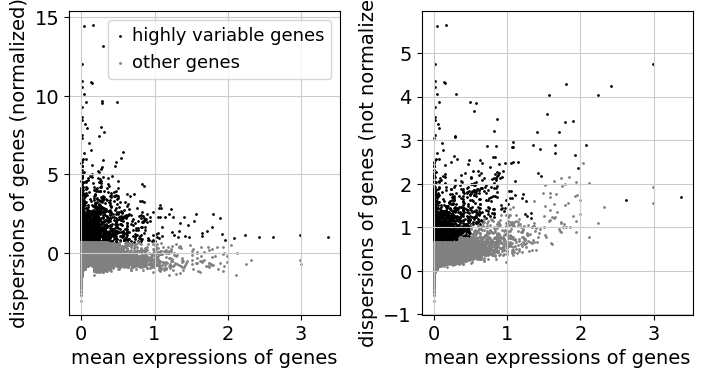

In [20]:
# Reduce dimensionality of the dataset to include only the most informative genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample_id")
sc.pl.highly_variable_genes(adata)

In [21]:
# Set the .raw atrribute of the AnnData object to the normalised and logarithmized raw gene expression
adata.raw = adata

### Dimensionality Reduction

In [22]:
# Reduce the dimensionality of the data by running Principal Component Analysis (PCA)
# PCA reveals the main axes of variation and denoises the data
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:01)


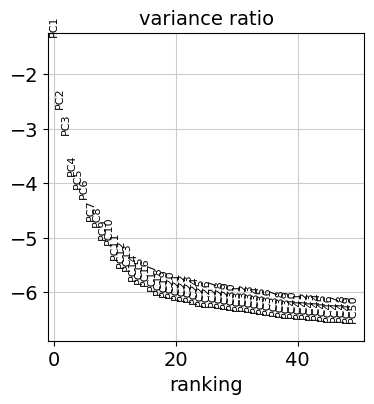

In [23]:
# Visualise the contribution of single PCs to the total variance in the data
# Answers the question of "How many PCs to consider in downstream analysis?"
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

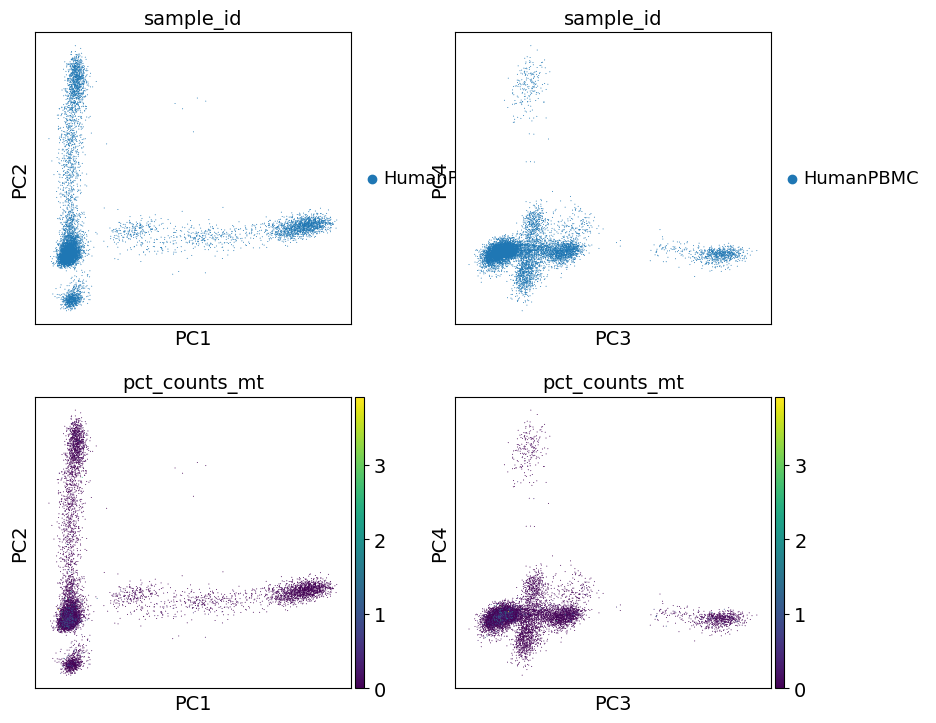

In [24]:
# Visualise PCs using specified dimensions
sc.pl.pca(
    adata,
    color=["sample_id", "sample_id", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

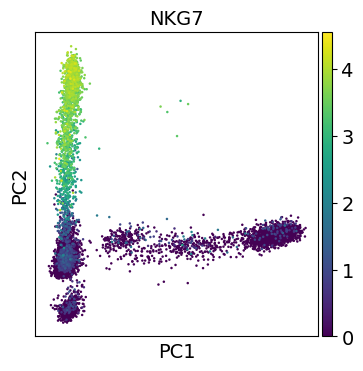

In [25]:
# Visualise PCs based on the expression levels of a gene
sc.pl.pca(adata, color="NKG7")

In [26]:
# Save the result
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 9347 × 14593
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'sample_id', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'sample_id_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

### Computing the Neighborhood Graph

In [28]:
# Compute neighborhood graph of cells using the PCA representation od the data matrix
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


### Embedding the Neighborhood Graph

In [30]:
# Embedding the graph in two dimensions using UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


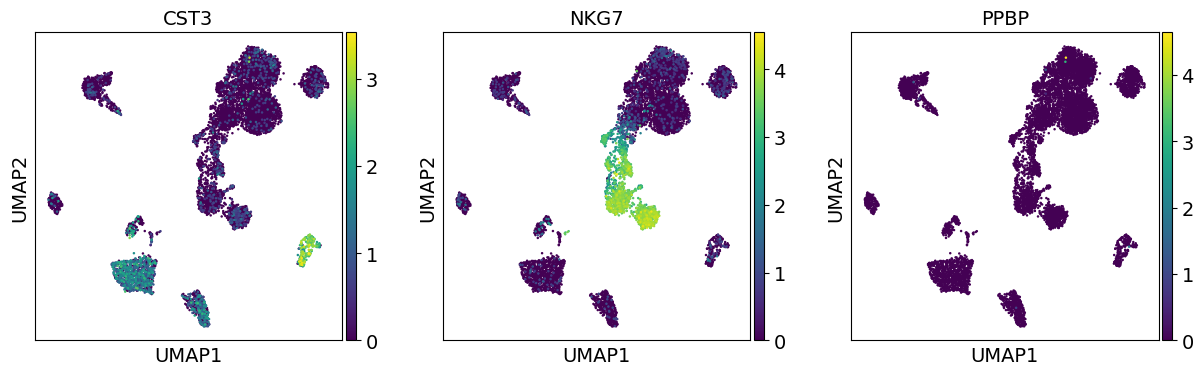

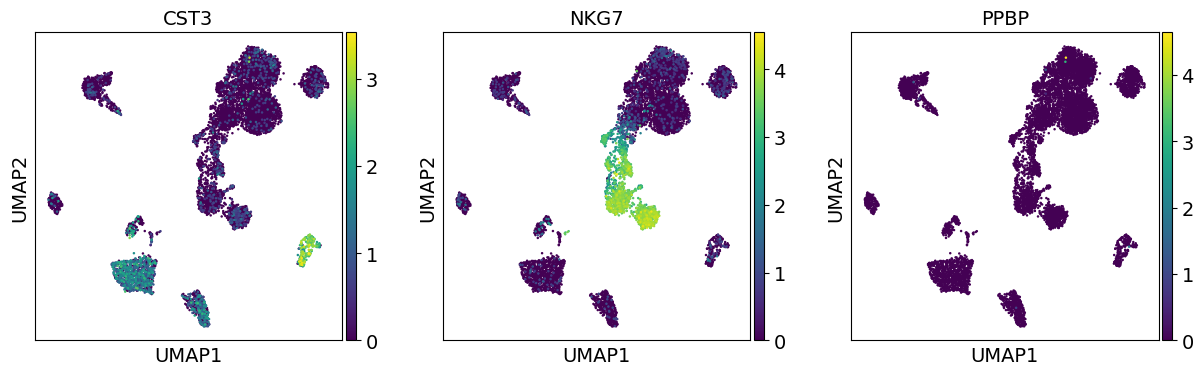

In [36]:
# Visualise UMAP based on the expression levels of genes
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

# Also plot the scaled and corrected gene expreesion
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

### Clustering the Neighborhood Graph

In [41]:
# Clustering done using the Leiden graph-clustering method
# A community detection based on optimizing modularity
sc.tl.leiden(adata, resolution=0.9, random_state=0, flavor="igraph", n_iterations=2, directed=False)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


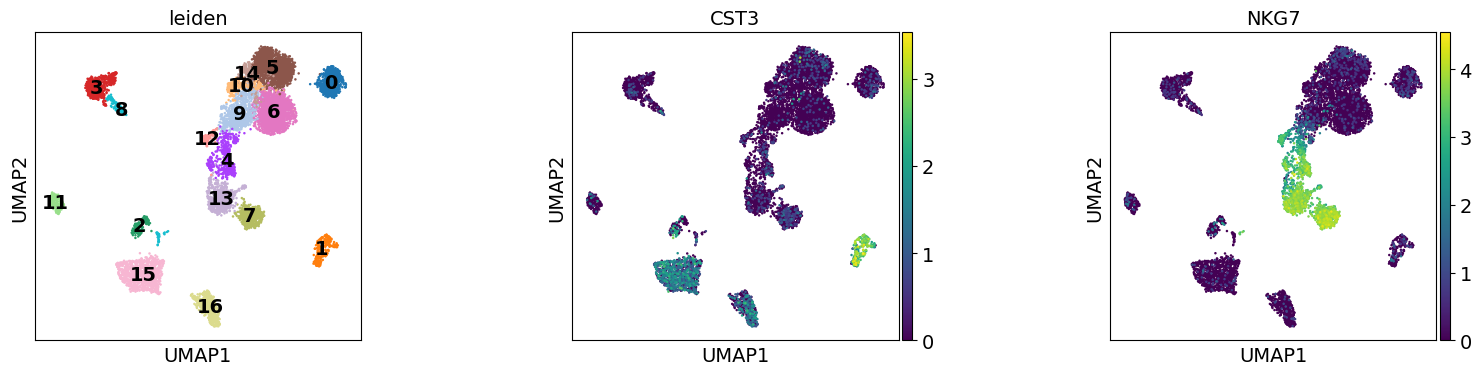

In [43]:
# Plot clusters
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"], wspace=0.5, legend_loc="on data")

### Re-assess Quality Control and Cell Filtering

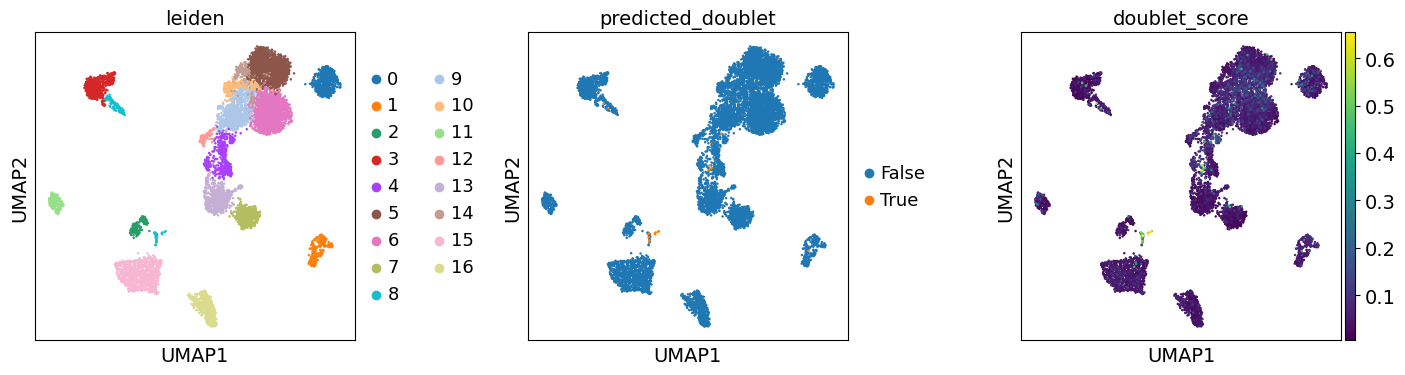

In [47]:
# re-assess filtering strategy by visualizing different QC metrics using UMAP
sc.pl.umap(adata, color=["leiden", "predicted_doublet", "doublet_score"], wspace=0.4)

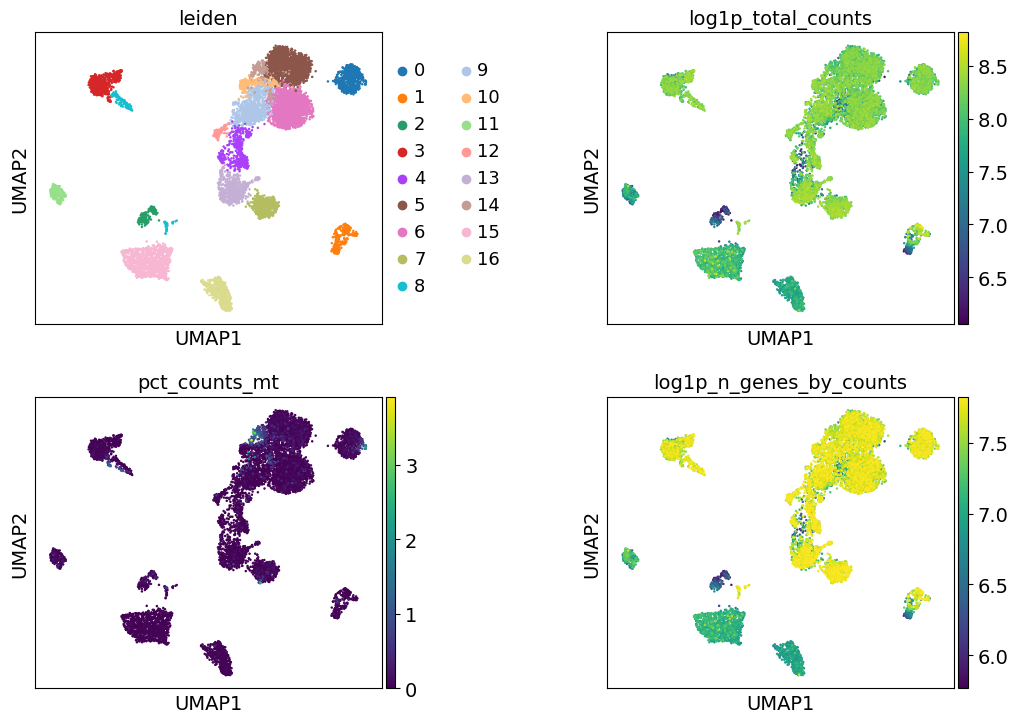

In [48]:
sc.pl.umap(
    adata, color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

### Manual Cell-Type Annotation

In [58]:
# Use the leiden clustering algorithm to extract cell communities from the nearest neighbors graph
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor='igraph')

running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res_0.02', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 29 clusters and added
    'leiden_res_2.00', the cluster labels (adata.obs, categorical) (0:00:00)


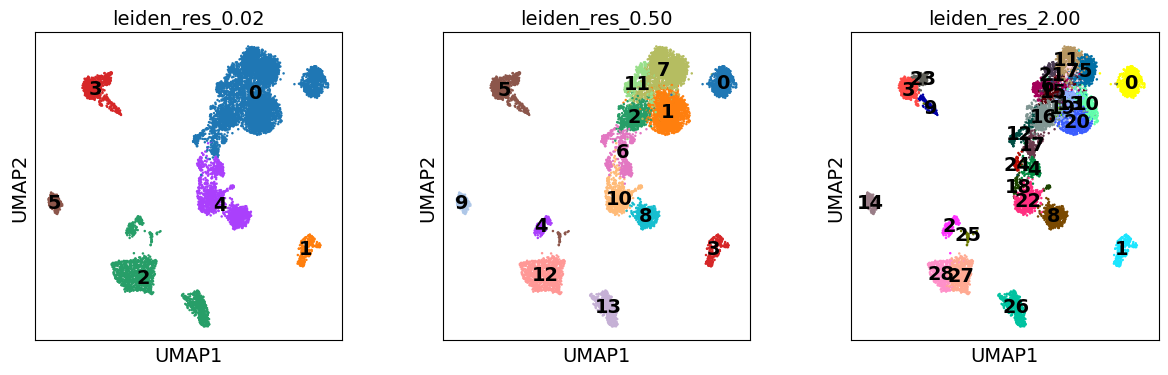

In [73]:
# Visulaise the UMAP cluster plots at different resolutions
sc.pl.umap(adata, color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"], legend_loc="on data")

### Finding Marker Genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


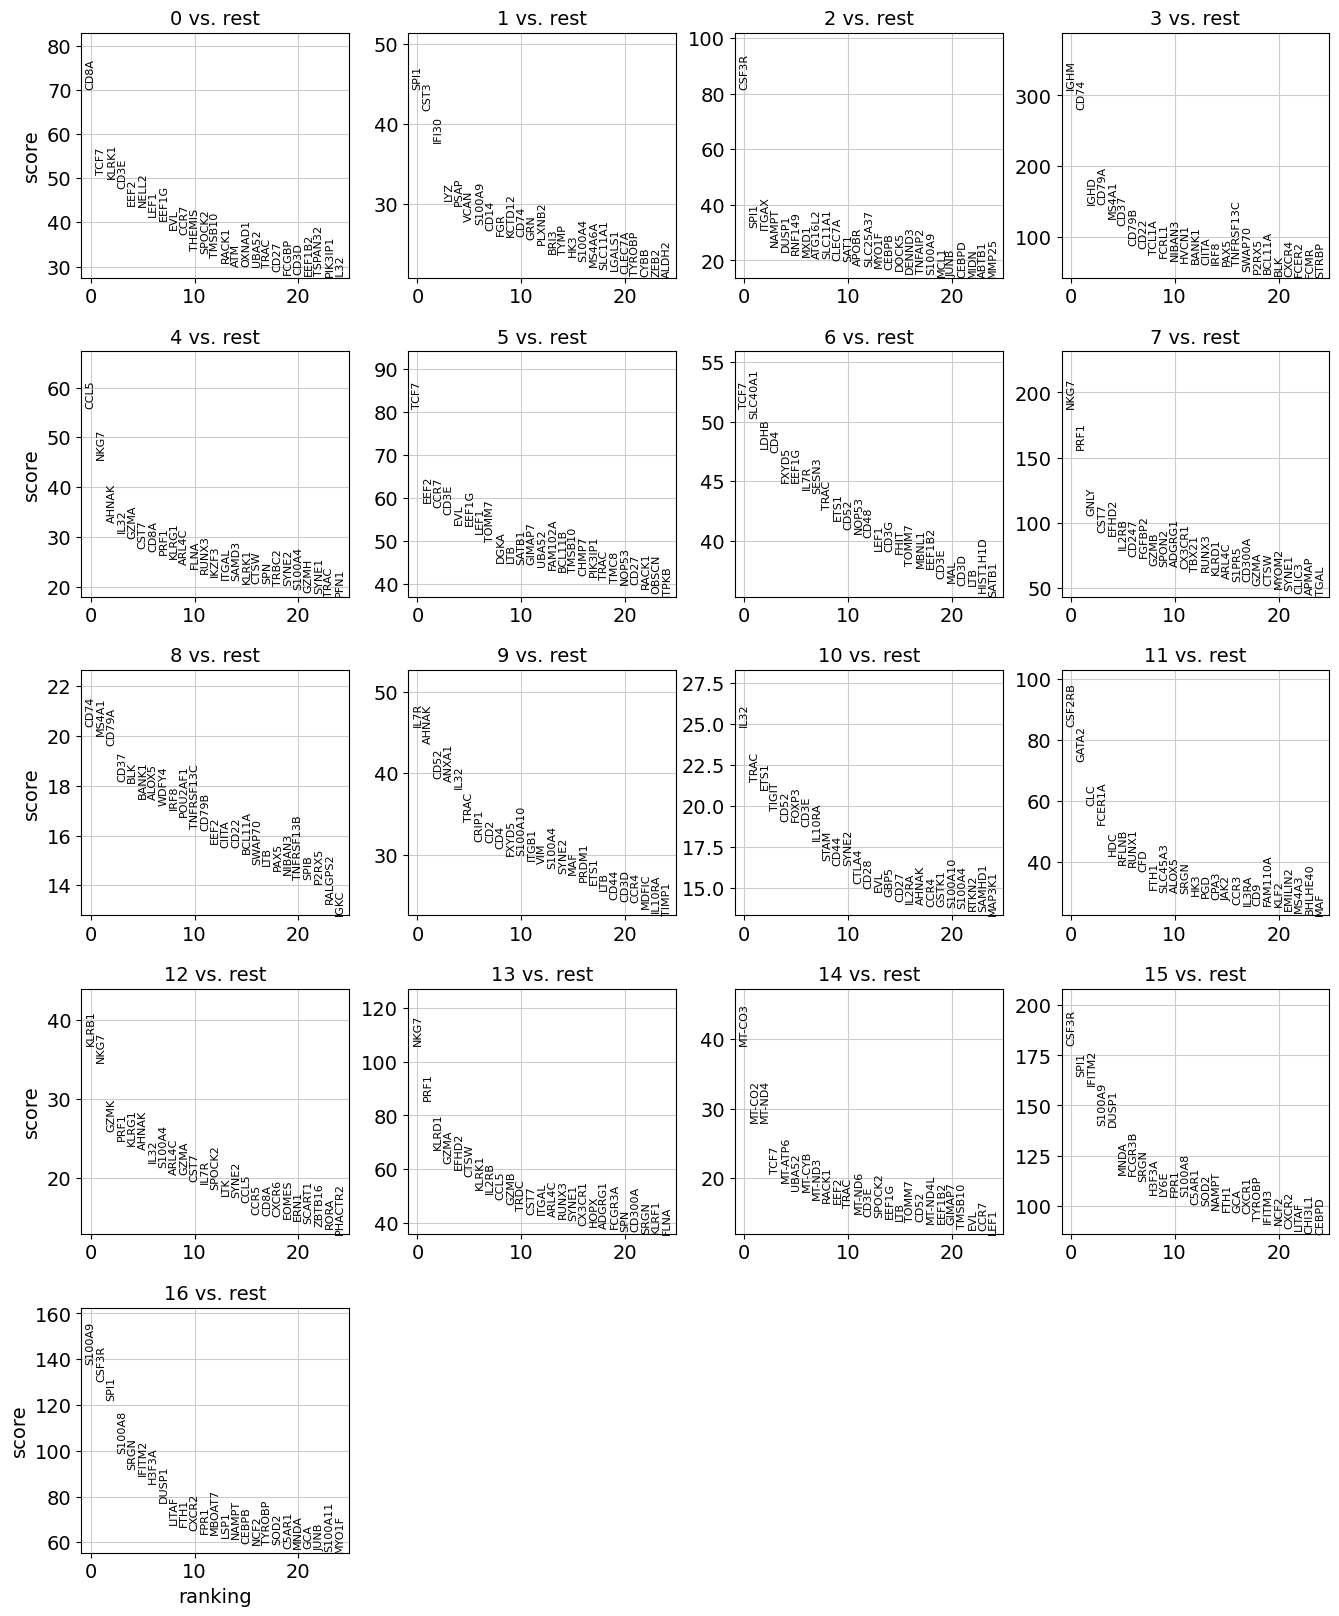

In [52]:
# Compute ranking for the highly differential genes in each cluster
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


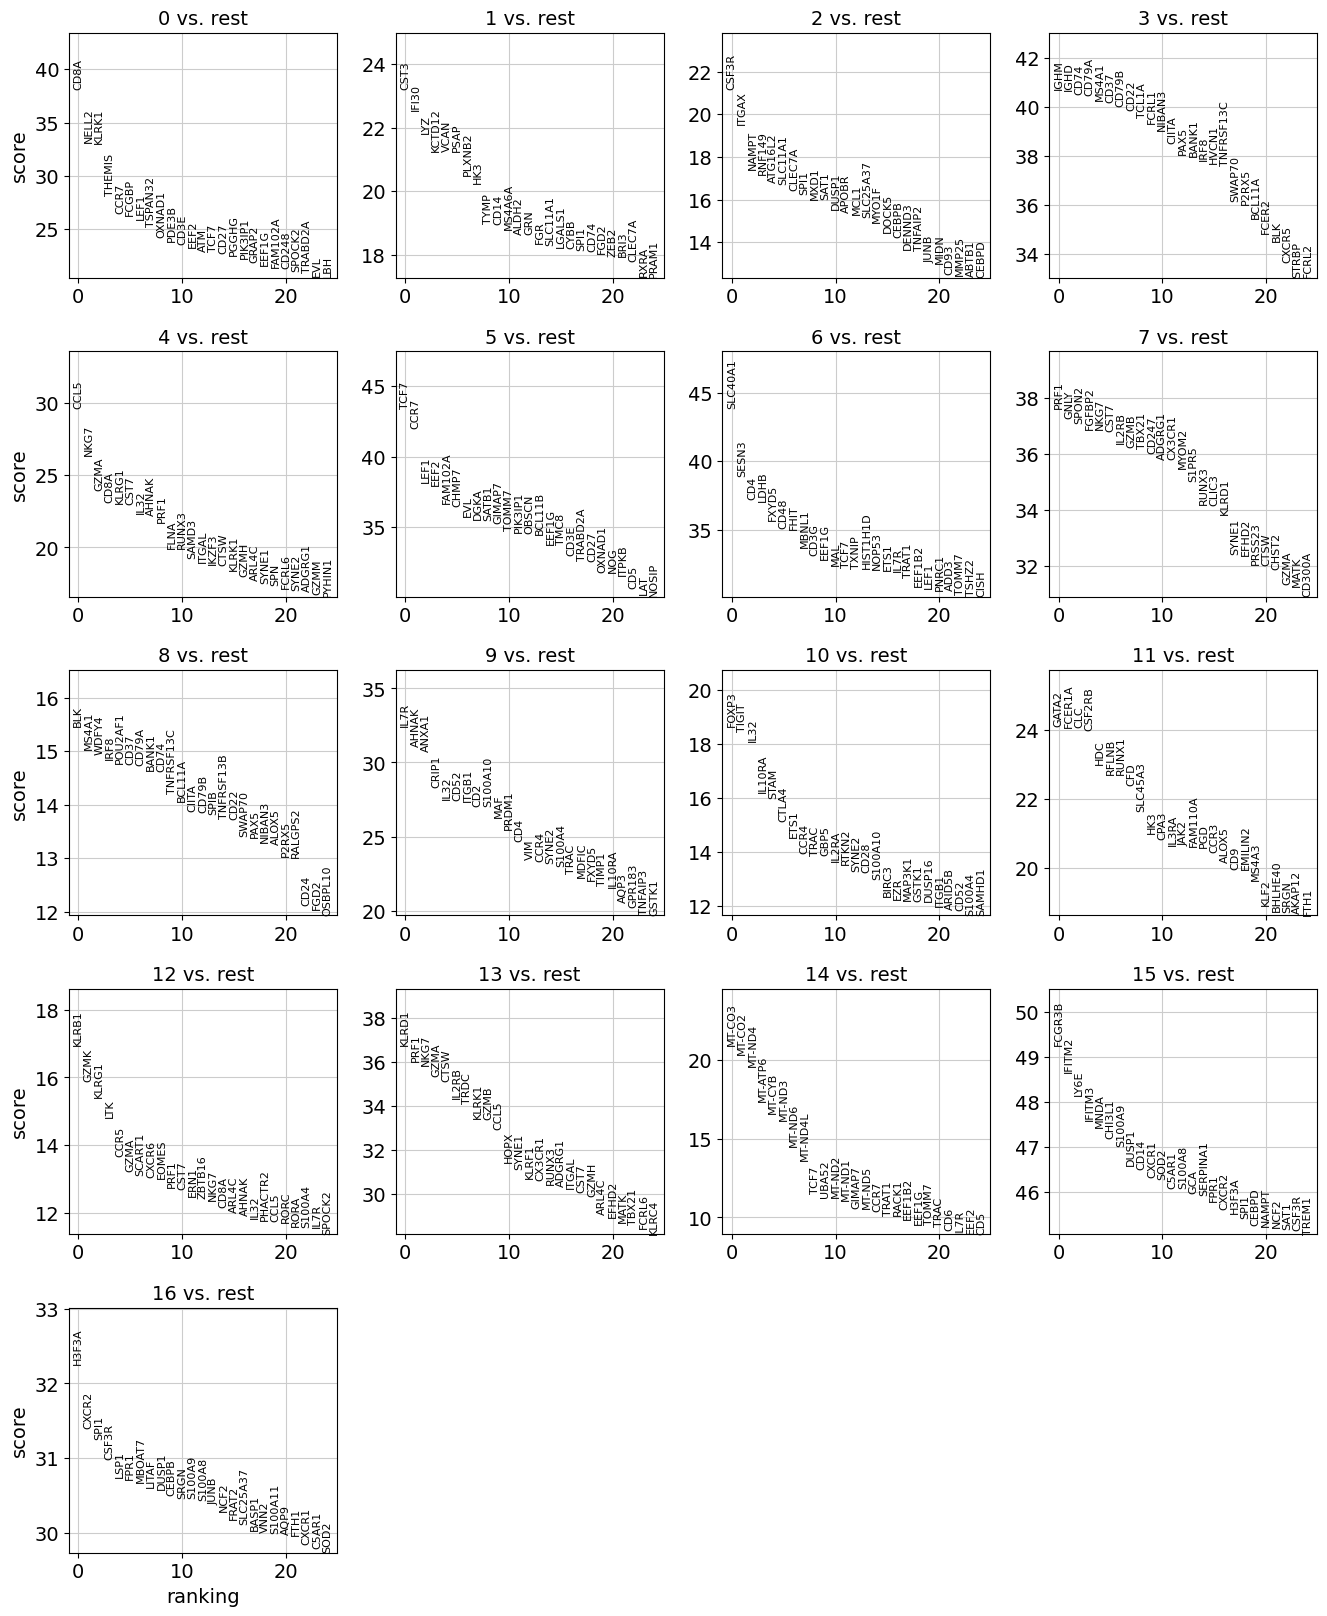

In [53]:
# Compute ranking using the Wilcoxon rank-sum (Mann-Whitney-U)
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [55]:
# Save the result
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:07:50)


/home/eaderogba279/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


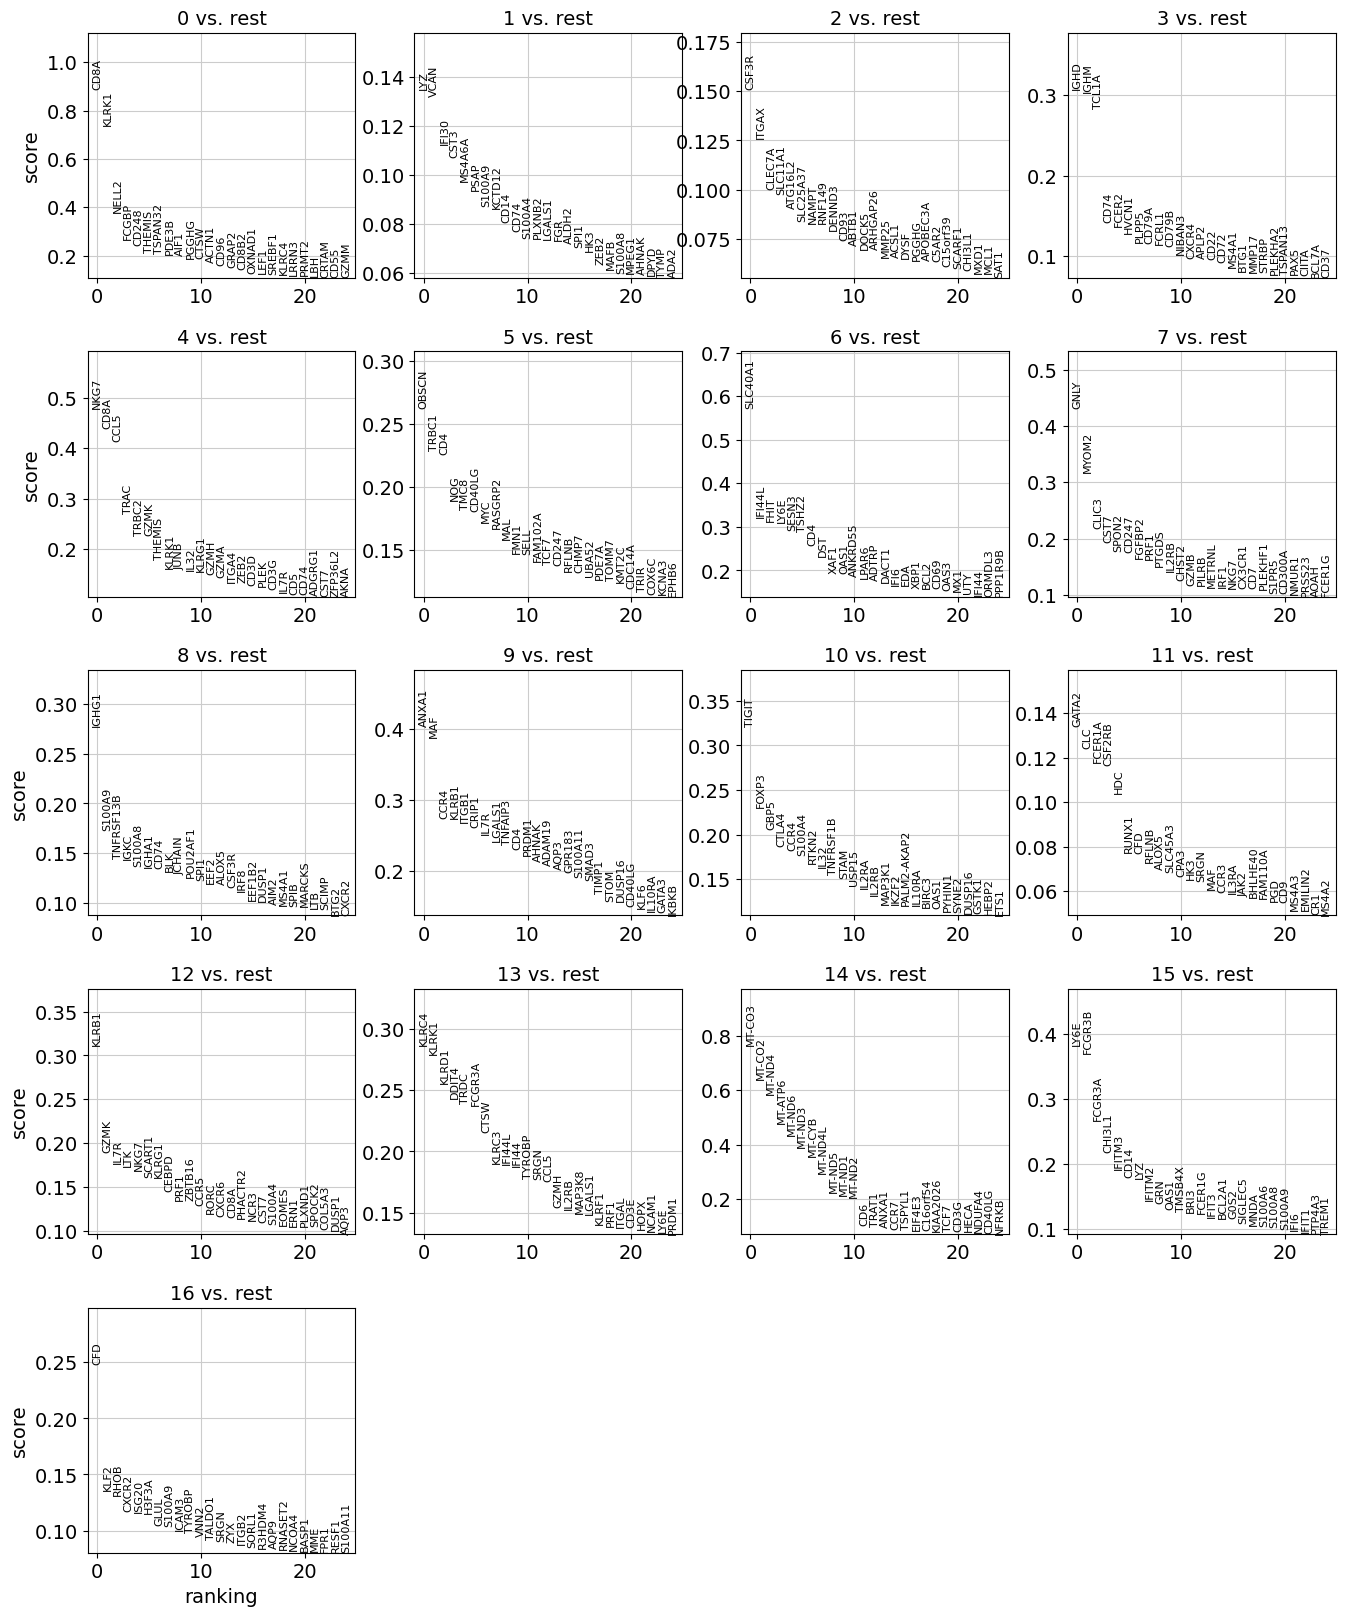

In [56]:
# Compute ranking using logistic regression
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [64]:
marker_genes = {
    "CD14+ Mono": ["CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

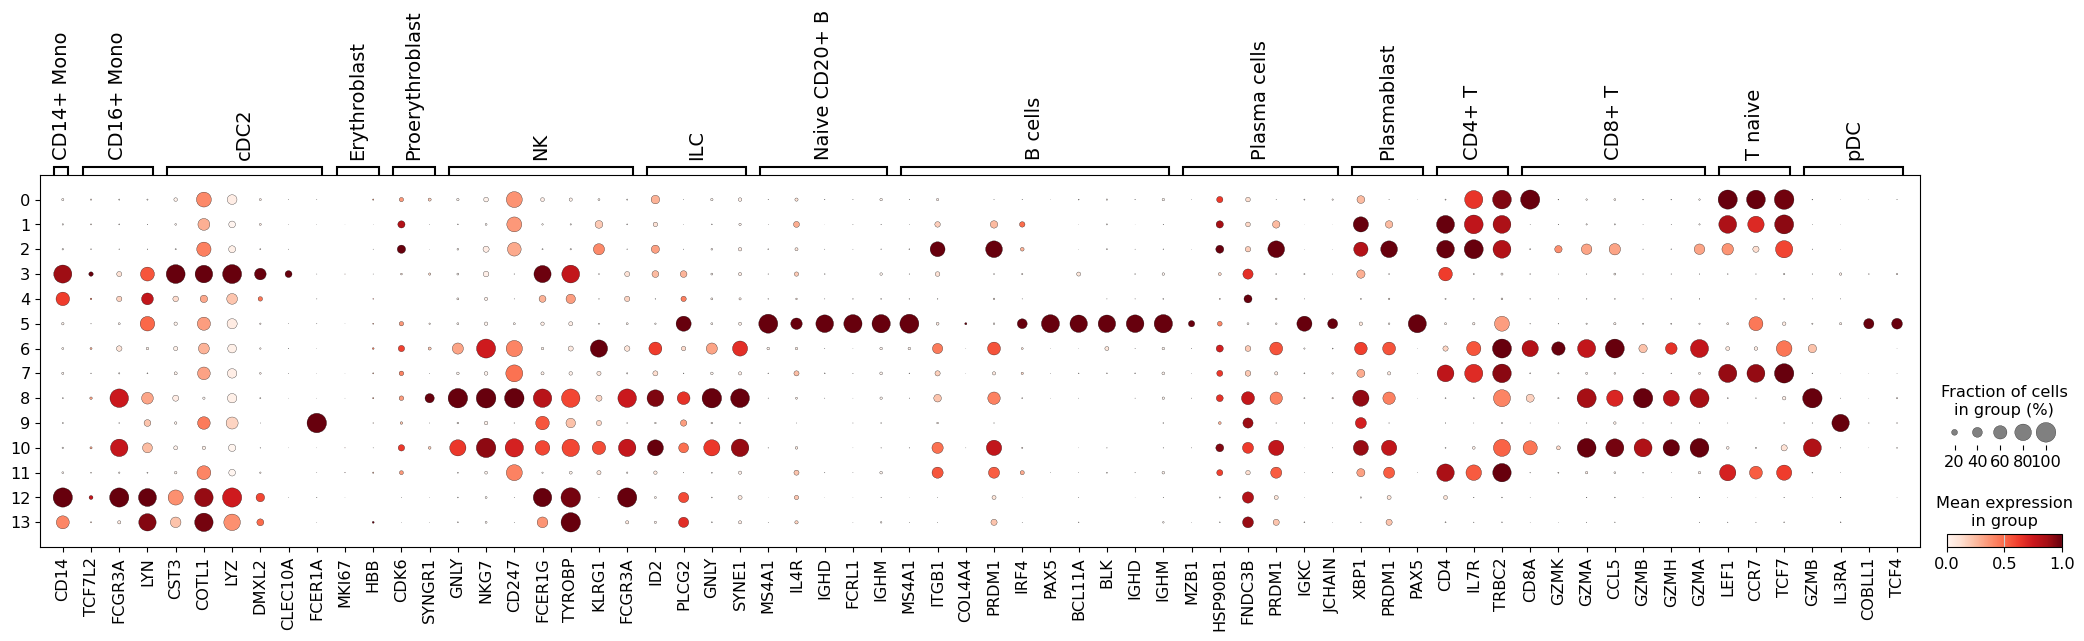

In [74]:
# Visulaise pattern of expression of markers
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

In [66]:
adata.obs["call_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

### Differentially_expressed Genes as Markers

In [75]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0.50']`


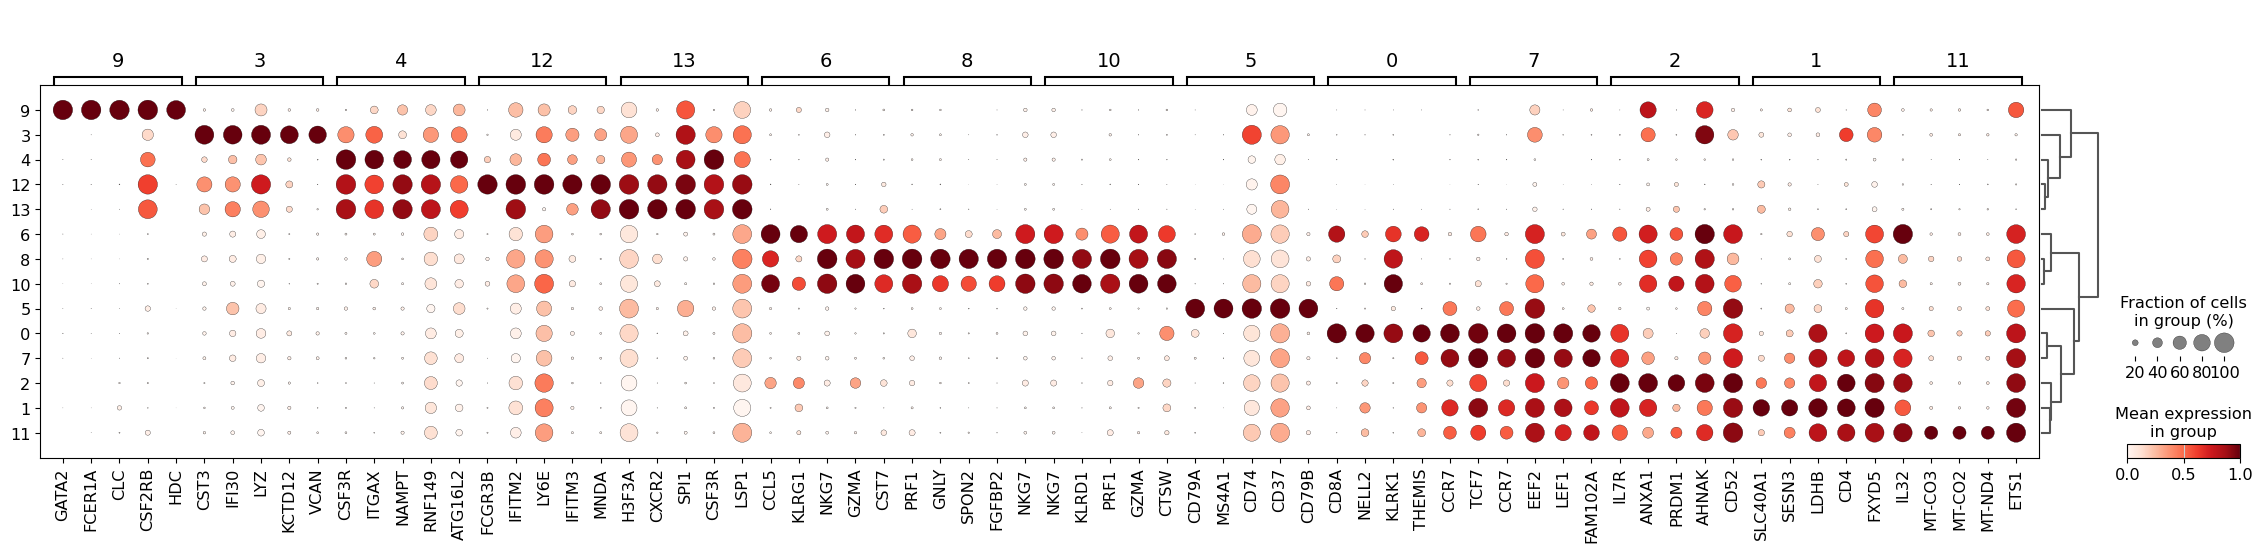

In [77]:
# Visulaise the top 5 differentially-expressed genes on a dotplot
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5)

In [82]:
# Extract the differentially expressd genes
sc.get.rank_genes_groups_df(adata, group="7").head(10)

names     scores  logfoldchanges          pvals      pvals_adj
0     TCF7  44.882278        2.477304   0.000000e+00   0.000000e+00
1     CCR7  40.886288        2.269179   0.000000e+00   0.000000e+00
2     EEF2  40.018951        1.473878   0.000000e+00   0.000000e+00
3     LEF1  39.385246        2.152996   0.000000e+00   0.000000e+00
4  FAM102A  39.069950        2.067645   0.000000e+00   0.000000e+00
5   GIMAP7  37.849453        1.747205   0.000000e+00   0.000000e+00
6      EVL  37.461159        1.430300  3.953708e-307  8.242351e-304
7     DGKA  36.910511        1.717562  3.134333e-298  5.717415e-295
8    TOMM7  36.292255        1.459322  2.143555e-288  3.475655e-285
9    CHMP7  36.196484        1.889435  6.914646e-287  1.009054e-283

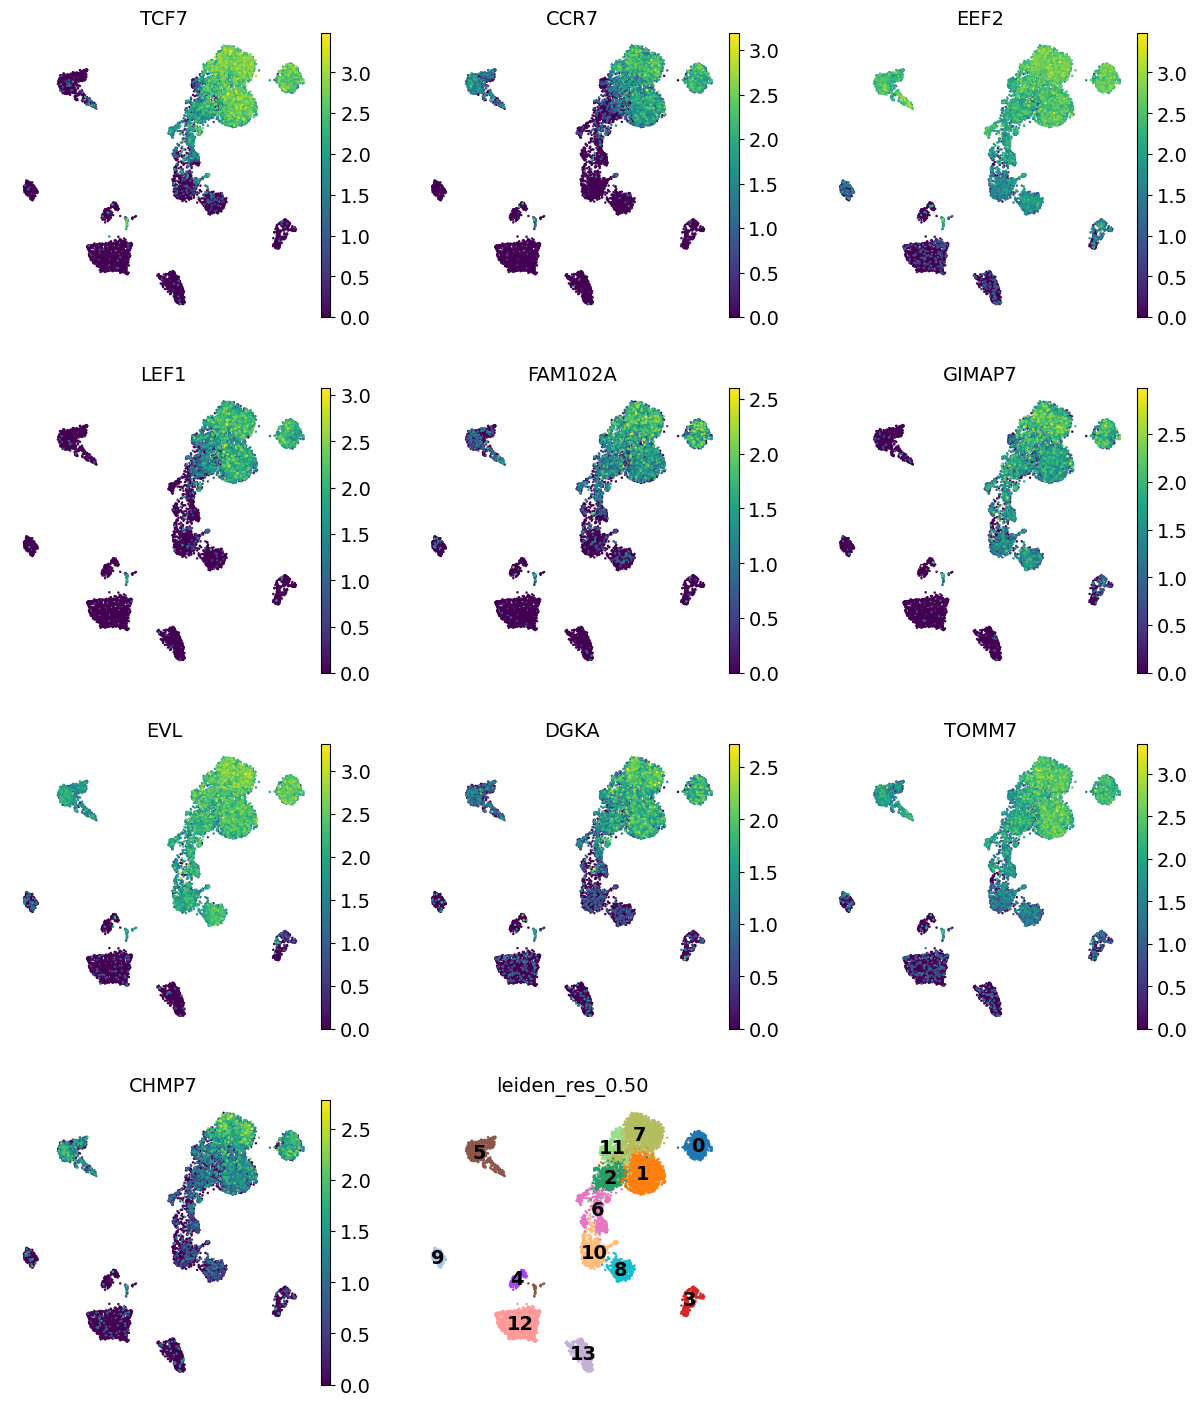

In [83]:
# Plot the UMAP cluster for the top ranked genes
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(10)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)